## Liver tumour Detection

### 1) Import Needed Modules

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow import keras
from numba import cuda

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")

Loading Libraries Done


### 2) Data loading

In [2]:
main_folder = "liver-tumour-bmp-images"
RANDOM_SEED = 6

categories = os.listdir(main_folder)
try:
    categories.remove(".DS_Store")
except:
    pass
print(categories, len(categories))



['Normal', 'Tumour'] 2


In [3]:
TOTAL_CATEGORIES = len(categories)
IMAGE_SIZE = (224,224,3)

def load_images_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        print(index, category)
        for image_name in tqdm(os.listdir(main_folder+"/"+category)):
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg") or (file_ext.lower() == "png") or (file_ext.lower() == "bmp"):
              try:
                    imgname = main_folder+"/"+category+"/"+image_name
                    imgname = imgname.replace("//", "/")
                    img = cv2.imread(imgname)
                    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    img_rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    img_rotated_180 = cv2.rotate(img, cv2.ROTATE_180)
                    img_rotated_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    img_flip_ver = cv2.flip(img, 0)
                    img_flip_hor = cv2.flip(img, 1)

                    img_array = Image.fromarray(img, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_90, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_90, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_180, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_270, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_ver, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_hor, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

              except:
                    print(imgname)
                    print(img)
                

    return img_lst, labels

images, labels = load_images_labels(categories)
print()
print("Total Images Loaded:", len(images))

0 Normal


100%|██████████| 37/37 [00:00<00:00, 70.66it/s]


1 Tumour


100%|██████████| 79/79 [00:01<00:00, 50.73it/s]


Total Images Loaded: 812


In [4]:
images = np.array(images)
labels = np.array(labels)

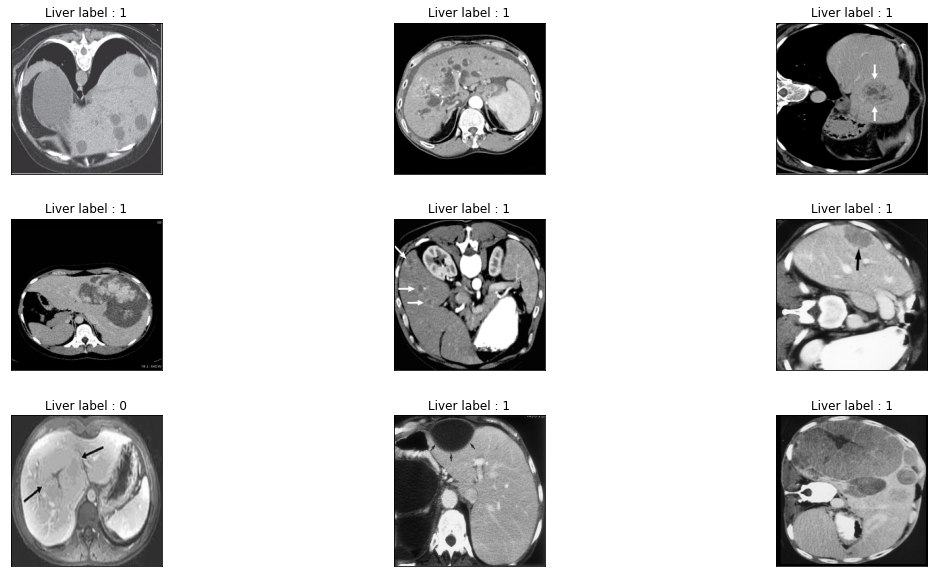

In [5]:
def display_random_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Liver label : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_random_images(images, labels)

In [6]:
np.random.seed(RANDOM_SEED)


n = np.arange(images.shape[0])
np.random.shuffle(n)

images = images[n]
labels = labels[n]

- Step 2 - Data normalization

In [7]:
images = images.astype(np.float32)
labels = labels.astype(np.int8)
images /= 255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (812, 224, 224, 3)


- Display few random images after normalization

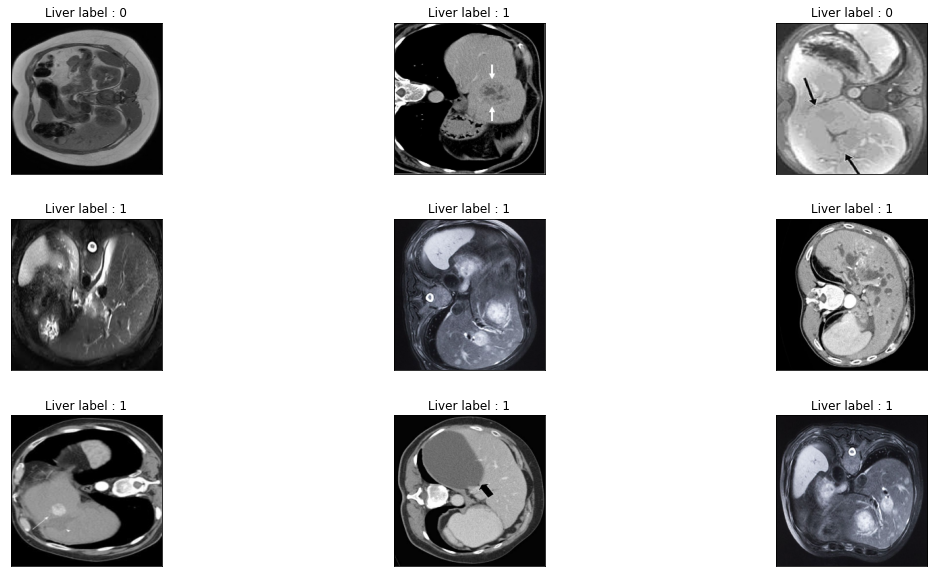

In [8]:
display_random_images(images, labels)

- Split dataset for training and testing

In [9]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = RANDOM_SEED)


print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (649, 224, 224, 3)
y_train shape =  (649,)

x_test shape =  (163, 224, 224, 3)
y_test shape =  (163,)


In [11]:
del labels
del images

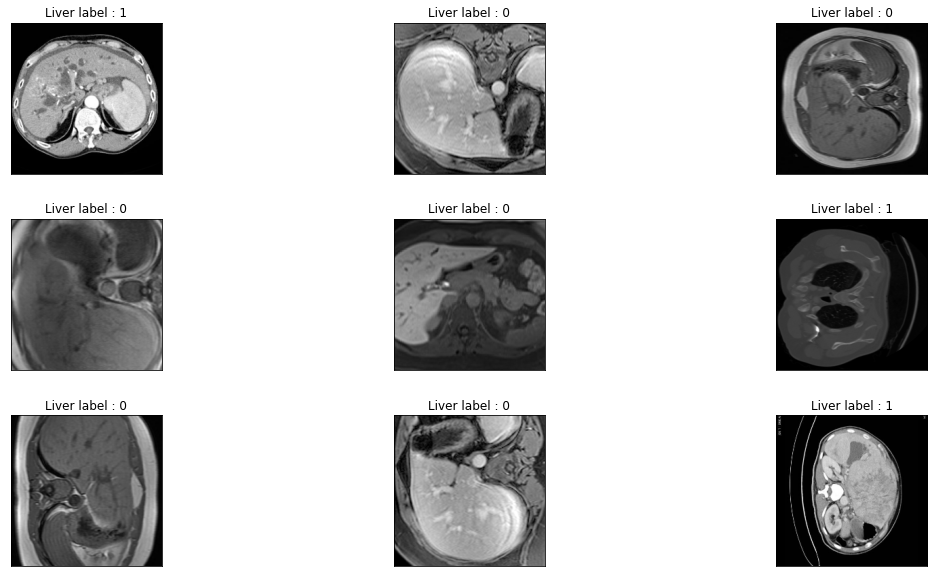

In [10]:
display_random_images(x_train, y_train)

In [12]:
EPOCHS = 10
BATCH_SIZE = 16


## VGG 19

In [13]:
vgg = VGG19(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [14]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [15]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
vgg_model = Model(inputs=vgg.input, outputs=prediction)
vgg_model.summary()# view the structure of the model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [17]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=15, restore_best_weights=True)

In [18]:
# fit the model
vgg_history = vgg_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/10
10/10 [==============================] - 161s 17s/step - loss: 1.6757 - accuracy: 0.5562 - val_loss: 0.8436 - val_accuracy: 0.7000
Epoch 2/10
10/10 [==============================] - 148s 16s/step - loss: 0.6135 - accuracy: 0.7625 - val_loss: 0.2827 - val_accuracy: 0.8687
Epoch 3/10
10/10 [==============================] - 150s 16s/step - loss: 0.2680 - accuracy: 0.8813 - val_loss: 0.2335 - val_accuracy: 0.8813
Epoch 4/10
10/10 [==============================] - 143s 15s/step - loss: 0.2658 - accuracy: 0.8938 - val_loss: 0.2955 - val_accuracy: 0.8562
Epoch 5/10
10/10 [==============================] - 120s 13s/step - loss: 0.0868 - accuracy: 0.9739 - val_loss: 0.1353 - val_accuracy: 0.9688
Epoch 6/10
10/10 [==============================] - 114s 12s/step - loss: 0.0639 - accuracy: 0.9937 - val_loss: 0.1106 - val_accuracy: 0.9625
Epoch 7/10
10/10 [==============================] - 118s 12s/step - loss: 0.0901 - accuracy: 0.9625 - val_loss: 0.1096 - val_accuracy: 0.9812
Epoch 

In [19]:
tf.keras.backend.clear_session()
vgg_loss, vgg_acc = vgg_model.evaluate(x_test,y_test,batch_size=32)
print("VGG 19 Loss:", vgg_loss)
print("VGG 19 Accuracy:", vgg_acc*100, "%")

6/6 [==============================] - 63s 10s/step - loss: 0.0781 - accuracy: 0.9816
VGG 19 Loss: 0.07811239361763
VGG 19 Accuracy: 98.15950989723206 %


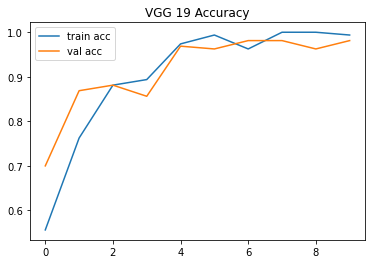

In [20]:
# accuracies
plt.plot(vgg_history.history['accuracy'], label='train acc')
plt.plot(vgg_history.history['val_accuracy'], label='val acc')
plt.title("VGG 19 Accuracy")
plt.legend()
plt.show()

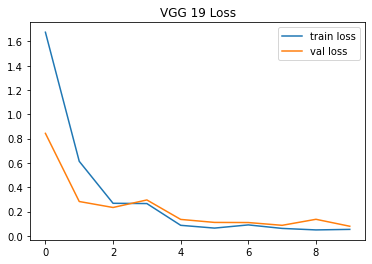

In [21]:
# loss
plt.plot(vgg_history.history['loss'], label='train loss')
plt.plot(vgg_history.history['val_loss'], label='val loss')
plt.title("VGG 19 Loss")
plt.legend()
plt.show()

In [22]:
#predict
y_pred = vgg_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,y_test))#get classification report

6/6 [==============================] - 59s 9s/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        52
           1       0.97      1.00      0.99       111

    accuracy                           0.98       163
   macro avg       0.99      0.97      0.98       163
weighted avg       0.98      0.98      0.98       163



In [23]:
print(confusion_matrix(y_pred,y_test))#get confusion matrix

vgg_model.save("liver_tumour_vgg_model.h5", save_format="h5")


[[ 49   3]
 [  0 111]]


In [24]:
del vgg_history
del y_pred

gc.collect()

60512

# RESNET 50

In [25]:
resnet_50 = ResNet50(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [26]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_50.layers:
    layer.trainable = False

In [27]:
x = Flatten()(resnet_50.output)

#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_model = Model(inputs=resnet_50.input, outputs=prediction)
resnet_50_model.summary()# view the structure of the model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [28]:
resnet_50_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [30]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

In [31]:
# fit the model
resnet_50_history = resnet_50_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = x_train.shape[0]//BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/10
40/40 [==============================] - 114s 3s/step - loss: 1.3230 - accuracy: 0.7234 - val_loss: 0.4262 - val_accuracy: 0.8000
Epoch 2/10
40/40 [==============================] - 111s 3s/step - loss: 0.5297 - accuracy: 0.8420 - val_loss: 0.3461 - val_accuracy: 0.8313
Epoch 3/10
40/40 [==============================] - 117s 3s/step - loss: 0.4580 - accuracy: 0.8436 - val_loss: 0.3598 - val_accuracy: 0.8500
Epoch 4/10
40/40 [==============================] - 109s 3s/step - loss: 0.3672 - accuracy: 0.8705 - val_loss: 0.4194 - val_accuracy: 0.8250
Epoch 5/10
40/40 [==============================] - 96s 2s/step - loss: 0.1794 - accuracy: 0.9336 - val_loss: 0.2422 - val_accuracy: 0.8938
Epoch 6/10
40/40 [==============================] - 90s 2s/step - loss: 0.1958 - accuracy: 0.9147 - val_loss: 0.4391 - val_accuracy: 0.8062
Epoch 7/10
40/40 [==============================] - 92s 2s/step - loss: 0.1238 - accuracy: 0.9463 - val_loss: 0.2365 - val_accuracy: 0.8938
Epoch 8/10
40/40

In [32]:
resnet_50_loss,resnet_50_acc = resnet_50_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50 Loss:", resnet_50_loss)
print("Resnet_50 Accuracy:", resnet_50_acc*100, "%")

6/6 [==============================] - 21s 4s/step - loss: 0.1845 - accuracy: 0.9080
Resnet_50 Loss: 0.184528648853302
Resnet_50 Accuracy: 90.7975435256958 %


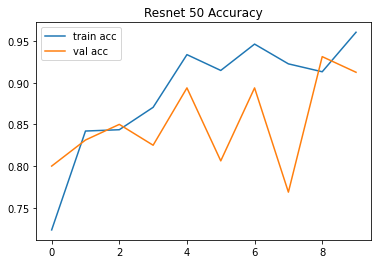

In [33]:
# accuracies
plt.plot(resnet_50_history.history['accuracy'], label='train acc')
plt.plot(resnet_50_history.history['val_accuracy'], label='val acc')
plt.title("Resnet 50 Accuracy")
plt.legend()
plt.show()

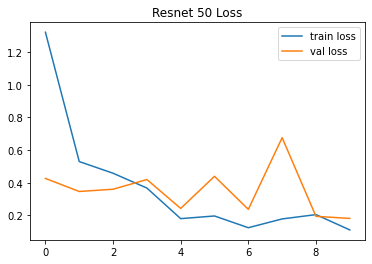

In [34]:
# loss
plt.plot(resnet_50_history.history['loss'], label='train loss')
plt.plot(resnet_50_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 Loss")
plt.legend()
plt.show()

In [35]:
#predict
y_pred=resnet_50_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

6/6 [==============================] - 31s 5s/step
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        56
           1       0.90      0.96      0.93       107

    accuracy                           0.91       163
   macro avg       0.91      0.88      0.89       163
weighted avg       0.91      0.91      0.91       163



In [36]:
resnet_50_model.save("liver_tumour_resnet_50_model.h5", save_format="h5")

In [37]:
del resnet_50_history
del y_pred

gc.collect()

8983

## RESNET 50V2

In [38]:
resnet_50_v2 = ResNet50V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [39]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_50_v2.layers:
    layer.trainable = False

In [40]:
x = Flatten()(resnet_50_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_v2_model = Model(inputs=resnet_50_v2.input, outputs=prediction)
# view the structure of the model
resnet_50_v2_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [41]:
resnet_50_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

In [42]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

In [43]:
# fit the model
resnet_50_v2_history = resnet_50_v2_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = x_train.shape[0]//BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/10
40/40 [==============================] - 103s 2s/step - loss: 0.5537 - acc: 0.7563 - val_loss: 0.2246 - val_acc: 0.9187
Epoch 2/10
40/40 [==============================] - 95s 2s/step - loss: 0.2338 - acc: 0.9052 - val_loss: 0.1128 - val_acc: 0.9563
Epoch 3/10
40/40 [==============================] - 88s 2s/step - loss: 0.1584 - acc: 0.9384 - val_loss: 0.0791 - val_acc: 0.9750
Epoch 4/10
40/40 [==============================] - 86s 2s/step - loss: 0.0818 - acc: 0.9731 - val_loss: 0.0834 - val_acc: 0.9688
Epoch 5/10
40/40 [==============================] - 88s 2s/step - loss: 0.0611 - acc: 0.9779 - val_loss: 0.0219 - val_acc: 1.0000
Epoch 6/10
40/40 [==============================] - 90s 2s/step - loss: 0.0561 - acc: 0.9795 - val_loss: 0.0211 - val_acc: 0.9937
Epoch 7/10
40/40 [==============================] - 87s 2s/step - loss: 0.0421 - acc: 0.9826 - val_loss: 0.0522 - val_acc: 0.9875
Epoch 8/10
40/40 [==============================] - 73s 2s/step - loss: 0.0509 - acc: 0.9

In [44]:
resnet_50_v2_loss,resnet_50_v2_acc = resnet_50_v2_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50_V2 Loss:", resnet_50_v2_loss)
print("Resnet_50_V2 Accuracy:", resnet_50_v2_acc*100, "%")

6/6 [==============================] - 15s 2s/step - loss: 0.0121 - acc: 0.9939
Resnet_50_V2 Loss: 0.012137691490352154
Resnet_50_V2 Accuracy: 99.38650131225586 %


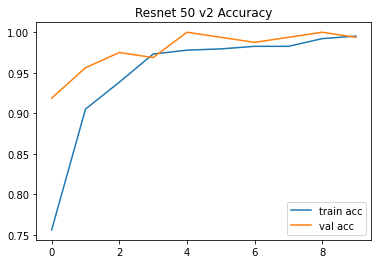

In [45]:
# accuracies
plt.plot(resnet_50_v2_history.history['acc'], label='train acc')
plt.plot(resnet_50_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 50 v2 Accuracy")
plt.legend()
plt.show()

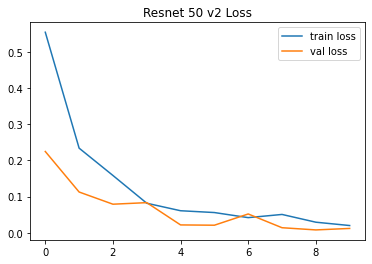

In [46]:
# loss
plt.plot(resnet_50_v2_history.history['loss'], label='train loss')
plt.plot(resnet_50_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 v2 Loss")
plt.legend()
plt.show()

In [47]:
#predict
y_pred=resnet_50_v2_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

6/6 [==============================] - 18s 3s/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.99      1.00      1.00       113

    accuracy                           0.99       163
   macro avg       1.00      0.99      0.99       163
weighted avg       0.99      0.99      0.99       163



In [48]:
resnet_50_v2_model.save("liver_tumour_resnet_50_v2_model.h5", save_format="h5")

In [49]:
#get confusion matrix
print(confusion_matrix(y_pred,y_test))

del resnet_50_v2_history
del y_pred

gc.collect()

[[ 49   1]
 [  0 113]]


8872

[98.15950989723206, 90.7975435256958, 99.38650131225586]


Text(0.5, 1.0, 'Accuracy score Comparison during (Higher is better)')

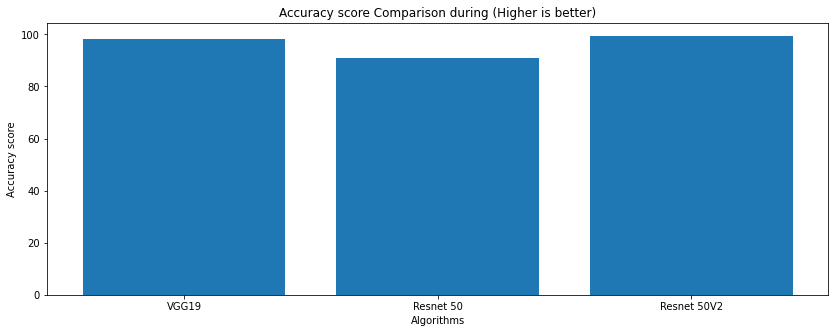

In [50]:
algorithms = ["VGG19","Resnet 50","Resnet 50V2"]
Accuracy = [vgg_acc*100,resnet_50_acc*100,resnet_50_v2_acc*100]
print(Accuracy)

plt.figure(figsize=[14,5])
plt.bar(algorithms, Accuracy)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")
plt.title("Accuracy score Comparison during (Higher is better)")